In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import os

import h5py
import numpy as np
import seaborn as sns

from astropy import constants as const
from astropy import units as u

from injection_helpers import snapshot_to_energy_file

 
# Note: these units differ from the ones in `units.py`
# These match the code units (M_sun, pc, Myr), while `units.py` uses cgs

m_p = const.m_p.cgs.to(u.M_sun).value

cm = u.cm.to(u.pc)
g = u.g.to(u.M_sun)

initial_metallicity = 0.02 # gas-phase mas fraction

In [2]:
n_part_per_side_unscaled = 400

In [3]:
run_name = "cluster_cooling_{}-perturbed".format(n_part_per_side_unscaled)

inputs_dir  = os.path.join("../runs", run_name, "inputs")
outputs_dir = os.path.join("../runs", run_name, "outputs")

IC_filename = os.path.join(inputs_dir, "{}_ics.hdf5".format(run_name))

print(inputs_dir)
print(outputs_dir)

print(IC_filename)

../runs/cluster_cooling_400-perturbed/inputs
../runs/cluster_cooling_400-perturbed/outputs
../runs/cluster_cooling_400-perturbed/inputs/cluster_cooling_400-perturbed_ics.hdf5


In [4]:
if "mhd" in run_name:
    with_MHD = True
else:
    with_MHD = False
    
print("with_MHD:         ", with_MHD)

with_MHD:          False


In [5]:
# initially I used single precision snapshot files, but that led to issues
# now I use double precision by default, but I've still left the capability 
# to create single precision initial conditions, by setting this flag to `False`
double_precision = True 
    
print("double_precision: ", double_precision)

double_precision:  True


# Seed RNG for mass perturbation field

In [6]:
# should match the grid size of the 1pc resolution run, 
# with box_size=600 pc
big_shape = [600, 600, 600]

perturbation_rms = 0.05 # normalized by the mean

In [7]:
import h5py

perturbation_filename = "mass_perturbations.hdf5"
if not os.path.exists(perturbation_filename):
    print("generating perturbation field")
    
    np.random.seed(0)
    perturbations = np.random.normal(scale=perturbation_rms, size=big_shape)
    np.random.seed() # back to device-generated seed

    print("creating: ", perturbation_filename)
    
    with h5py.File(perturbation_filename, "w") as hf:
        hf.create_dataset("perturbations", data=perturbations)

else:
    print("reusing perturbation field")
    with h5py.File(perturbation_filename, "r") as hf:
        perturbations = hf["perturbations"][:]
    

reusing perturbation field


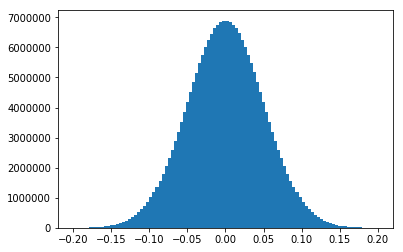

In [8]:
x = np.linspace(-.2, .2)
plt.hist(perturbations.flatten(), range=(x.min(), x.max()), bins=100);


# Create cluster initial conditions

In [9]:
ic_file = h5py.File(IC_filename, "w")

In [10]:
header_group = ic_file.create_group("Header")
particles_group = ic_file.create_group("PartType0")

In [11]:
# use this multiplier to get the desired box size
# i.e. don't change the box_size line, 
# but do change n_part_per_side_unscaled to change resolution
multiplier = 1.5

box_size = int( multiplier*400 )
n_part_per_side = int( multiplier * n_part_per_side_unscaled )

dx = box_size / n_part_per_side

n_part_gas = n_part_per_side**3
n_part = np.array([n_part_gas, 0, 0, 0, 0, 0])

print(dx)

1.0


In [12]:
header_group.attrs["NumPart_ThisFile"] = n_part
header_group.attrs["NumPart_Total"]    = n_part
header_group.attrs["NumPart_Total_HighWord"] = np.zeros(6)

header_group.attrs["MassTable"] = np.zeros(6)

header_group.attrs["Time"] = 0.
header_group.attrs["Redshift"] = 0.
header_group.attrs["BoxSize"] = float(box_size)
header_group.attrs["NumFilesPerSnapshot"] = 1
header_group.attrs["Omega0"] = 0.0
header_group.attrs["OmegaLambda"] = 0.0
header_group.attrs["HubbleParam"] = 1.0
header_group.attrs["Flag_Sfr"] = 0
header_group.attrs["Flag_Cooling"] = 1
header_group.attrs["Flag_StellarAge"] = 0
header_group.attrs["Flag_Metals"] = 1
header_group.attrs["Flag_Feedback"] = 0
if double_precision:
    header_group.attrs["Flag_DoublePrecision"] = 1
else:
    header_group.attrs["Flag_DoublePrecision"] = 0
header_group.attrs["Flag_IC_Info"] = 0




In [13]:
if double_precision:
    float_size = 8
else:
    float_size = 4
    
print("float_size: ", float_size)

float_type = "<f{}".format(float_size)
int_type = "<u4"

particles_group.create_dataset("Coordinates",                (n_part_gas, 3), dtype=float_type)
particles_group.create_dataset("Density",                    (n_part_gas,  ), dtype=float_type)
particles_group.create_dataset("ElectronAbundance",          (n_part_gas,  ), dtype=float_type)
particles_group.create_dataset("InternalEnergy",             (n_part_gas,  ), dtype=float_type)
particles_group.create_dataset("Masses",                     (n_part_gas,  ), dtype=float_type)
particles_group.create_dataset("Metallicity",                (n_part_gas,  ), dtype=float_type)
particles_group.create_dataset("NeutralHydrogenAbundance",   (n_part_gas,  ), dtype=float_type)
particles_group.create_dataset("ParticleChildIDsNumber",     (n_part_gas,  ), dtype=int_type)
particles_group.create_dataset("ParticleIDGenerationNumber", (n_part_gas,  ), dtype=int_type)
particles_group.create_dataset("ParticleIDs",                (n_part_gas,  ), dtype=int_type)
particles_group.create_dataset("SmoothingLength",            (n_part_gas,  ), dtype=float_type)
particles_group.create_dataset("Velocities",                 (n_part_gas, 3), dtype=float_type)

if with_MHD:
    particles_group.create_dataset("MagneticField",          (n_part_gas, 3), dtype=float_type)

    # unused
    particles_group.create_dataset("DivergenceOfMagneticField",   (n_part_gas, ), dtype=float_type)
    particles_group.create_dataset("DivBcleaningFunctionPhi",     (n_part_gas, ), dtype=float_type)
    particles_group.create_dataset("DivBcleaningFunctionGradPhi", (n_part_gas, ), dtype=float_type)


float_size:  8


In [14]:
a = np.linspace(0,box_size,num=n_part_per_side+1)[1:]
x, y, z = np.meshgrid(a,a,a)

coords  = np.vstack([x.flatten(), y.flatten(), z.flatten()]).T
coords += dx * (np.random.random(size=coords.shape) - .5)*1e-3 
coords  = coords % box_size

particles_group["Coordinates"][...] = coords
del coords
del x
del y
del z

In [15]:
# Calculate e_int

# mean molecular weight determined by initializing a snapshot with T=10**4
#  set in the params file, then looking at the InternalEnergy of snapshot_000
#  -- may not hold for other metallicities?
mu = 1.2194864
# T = 1e4
T = 344.626350734159 # equilibrium value (yt actually infers this to be 178.97956248958883 K)
gamma = 5/3

e_int = const.k_B * (T * u.Kelvin) / mu / const.m_p / (gamma-1)
e_int = e_int.to(u.pc**2 / u.Myr**2).value

In [16]:
shape_1D = (n_part_gas, )
shape_2D = (n_part_gas, 3)

## Downsample perturbations if needed
**Note:** I can only handle downsamples of factors of 2 at this point. This could be extended include other prime factors of `perturbations.shape` (=600), but I don't have any need to put in that effort at this time.

In [17]:
# downsample perturbations if needed
assert(big_shape[0] >= n_part_per_side)
assert(big_shape[0] % n_part_per_side == 0)
assert(np.log2(big_shape[0]/n_part_per_side) % 1 == 0) # multiple of 2

downsample_factor = int(big_shape[0]/n_part_per_side)
print("downsample factor: ", downsample_factor)

downsample factor:  1


In [18]:
if downsample_factor == 1:
    print("skipping convolution")
    perturbations_filtered_flattened = perturbations.flatten()
else:

    kernel = np.zeros([downsample_factor+1]*3)

    half_dist = downsample_factor/2
    assert(half_dist % 1 == 0)
    half_dist = int(half_dist)

    for i in range(downsample_factor+1):
        for j in range(downsample_factor+1):
            for k in range(downsample_factor+1):
                _coords = (i, j, k)
                _coords_centered = np.array(_coords) - half_dist


                dist = (_coords_centered**2).sum()**.5

                if not (   ( half_dist in _coords_centered) \
                        or (-half_dist in _coords_centered)):
                    # has 1 unique nearest downsampled neighbor
                    kernel[_coords] = 1.
                elif dist < np.sqrt(2) * half_dist:
                    # has 2 unique nearest downsampled neighbors
                    kernel[_coords] = 1/2
                elif dist < np.sqrt(3) * half_dist:
                    # has 4 unique nearest downsampled neighbors
                    kernel[_coords] = 1/4
                else:
                    # has 8 unique nearest downsampled neighbors
                    assert(dist == np.sqrt(3)*half_dist)
                    kernel[_coords] = 1/8


    print(kernel.shape)
    print(kernel)

    kernel /= downsample_factor**3
    
    print("performing convolution")

    from scipy import ndimage
    perturbations_smoothed = ndimage.filters.convolve(perturbations,
                                                      kernel,
                                                      mode="wrap")

    perturbations_filtered_flattened = perturbations_smoothed[
        downsample_factor-1::downsample_factor,
        downsample_factor-1::downsample_factor,
        downsample_factor-1::downsample_factor,
    ].flatten()

    assert(np.all(perturbations_filtered_flattened > -1))

skipping convolution


## Back to the normal creation of ICs

In [19]:
density = 1.33 * m_p / cm**3
density *= (1 + perturbations_filtered_flattened)
particles_group["Density"][...] = np.full(shape_1D, density, dtype=float_type)
print("Finished: Density")

particles_group["ParticleIDs"][...] = np.arange(1, n_part_gas+1, dtype=int_type)
print("Finished: ParticleIDs")

particles_group["Velocities"][...] = np.full(shape_2D, 0, dtype=float_type)
print("Finished: Velocities")

particles_group["InternalEnergy"][...] = np.full(shape_1D, e_int, dtype=float_type)
print("Finished: InternalEnergy")

particles_group["Masses"][...] = np.full(shape_1D, dx**3 * density, dtype=float_type)
print("Finished: Masses")

## I *think* the following are correct for making this a valid snapshot file
particles_group["ElectronAbundance"][...] = np.full(shape_1D, 1., dtype=float_type)
print("Finished: ElectronAbundance")

particles_group["Metallicity"][...] = np.full(shape_1D, initial_metallicity, dtype=float_type)
print("Finished: Metallicity")

particles_group["NeutralHydrogenAbundance"][...] = np.full(shape_1D, 0., dtype=float_type)
print("Finished: NeutralHydrogenAbundance")

particles_group["ParticleChildIDsNumber"][...] = np.full(shape_1D, 0, dtype=int_type)
print("Finished: ParticleChildIDsNumber")

particles_group["ParticleIDGenerationNumber"][...] = np.full(shape_1D, 0, dtype=int_type)
print("Finished: ParticleIDGenerationNumber")

smoothing_length = 5.25 * (box_size/400) / (n_part_per_side/150) # approximating from existing uniform snapshots
particles_group["SmoothingLength"][...] = np.full(shape_1D, smoothing_length, dtype=float_type)
print("Finished: SmoothingLength")


if with_MHD:
    particles_group["MagneticField"][...] = np.full(shape_2D, [0,0,5], dtype=float_type)
    print("Finished: MagneticField")

    # unused
    particles_group["DivergenceOfMagneticField"][...]   = np.full(shape_1D, 0., dtype=float_type)
    print("Finished: DivergenceOfMagneticField")

    particles_group["DivBcleaningFunctionPhi"][...]     = np.full(shape_1D, 0., dtype=float_type)
    print("Finished: DivBcleaningFunctionPhi")

    particles_group["DivBcleaningFunctionGradPhi"][...] = np.full(shape_1D, 0., dtype=float_type)
    print("Finished: DivBcleaningFunctionGradPhi")


Finished: Density
Finished: ParticleIDs
Finished: Velocities
Finished: InternalEnergy
Finished: Masses
Finished: ElectronAbundance
Finished: Metallicity
Finished: NeutralHydrogenAbundance
Finished: ParticleChildIDsNumber
Finished: ParticleIDGenerationNumber
Finished: SmoothingLength


In [20]:
list(particles_group.keys())

['Coordinates',
 'Density',
 'ElectronAbundance',
 'InternalEnergy',
 'Masses',
 'Metallicity',
 'NeutralHydrogenAbundance',
 'ParticleChildIDsNumber',
 'ParticleIDGenerationNumber',
 'ParticleIDs',
 'SmoothingLength',
 'Velocities']

In [21]:
ic_file.close()

# Copy to outputs dir

In [22]:
import shutil

In [23]:
snapshot_000_filename = os.path.join(outputs_dir, "snapshot_000.hdf5")
shutil.copy2(IC_filename, snapshot_000_filename)

'../runs/cluster_cooling_400-perturbed/outputs/snapshot_000.hdf5'

# Create initial energy file:

First, delete any existing energy file:

In [24]:
energy_filename = os.path.join(outputs_dir, "energy.txt")

In [25]:
%rm -f $energy_filename

Now create a new energy file

In [26]:
snapshot_to_energy_file(snapshot_000_filename, energy_filename)

In [27]:
%cat  $energy_filename

0.00000000000000       2.5983112604e+07   0.0000000000e+00   0.0000000000e+00   2.5983112604e+07   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   7.0996379021e+06   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00   0.0000000000e+00


# What to do next?
 0) Make sure the params.base file is _actually_ using the correct box size.

 1) Add the first SN (`add_SN_to_snapshot.ipynb`)
 
 2) Create an initial params file (`create_new_params_file.ipynb`) 
 
 3) Start simulation using the respective `*_loop_test`